In [67]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import os

In [68]:
class Node :
    def __init__(self, id, coord_x, coord_y, date_available=0, E=0):
        self.id = id
        self.coord_x = coord_x
        self.coord_y = coord_y
        self.date_available = date_available
        self.E = E
        pass

    def __str__(self):
        return f"Node {self.id}"

class Arc :
    def __init__(self, From_node: Node, To_node: Node, technology: str):
        self.From_node = From_node
        self.To_node = To_node
        self.dist = ((From_node.coord_x-To_node.coord_x)**2 + (From_node.coord_y-To_node.coord_y)**2)**(1/2)
        self.technology = technology
        pass


class Network:
    def __init__(self, storage_sites: dict, capture_sites: dict, rail_matrix, param):
        self.storage_sites = storage_sites  # Dictionary of storage nodes
        self.capture_sites = capture_sites  # Dictionary of capture nodes
        self.rail_matrix = rail_matrix  # Matrix indicating rail connections
        self.nodes = list(self.storage_sites.values()) + list(self.capture_sites.values())
        self.arcs = []  # List to store Arc objects
        self.param = param
        self.output_folder = "data/small_instance/"
        os.makedirs(self.output_folder, exist_ok=True)

    def generate_arcs(self):
        
        # Create arcs with technology "A" and "B"
        for i in range(len(self.nodes)):
            for j in range(len(self.nodes)):
                if i != j:
                    self.arcs.append(Arc(self.nodes[i], self.nodes[j], "truck"))
                    self.arcs.append(Arc(self.nodes[i], self.nodes[j], "pipeline"))
                    
                    # Check rail matrix for technology "C"
                    if self.rail_matrix[i][j] == 1:
                        self.arcs.append(Arc(self.nodes[i], self.nodes[j], "train"))


    def visualize(self):
        plt.figure(figsize=(8, 6))
        nodes = list(self.storage_sites.values()) + list(self.capture_sites.values())
        
        # Plot nodes
        for node in nodes:
            plt.scatter(node.coord_x, node.coord_y, color='blue', s=100)
            plt.text(node.coord_x, node.coord_y, f"{node.id}", fontsize=12, ha='right')
        
        # Define colors for different technologies
        tech_colors = {"truck": "red", "pipeline": "green", "train": "blue"}
        
        # Plot arcs
        for arc in self.arcs:
            plt.plot([arc.From_node.coord_x, arc.To_node.coord_x], 
                     [arc.From_node.coord_y, arc.To_node.coord_y],
                     color=tech_colors.get(arc.technology, "black"), alpha=0.5, label=arc.technology)
        
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.title("Network Visualization")
        plt.show()

    def export_to_csv(self):
        # Export storage sites
        with open(os.path.join(self.output_folder, 'storage_sites.csv'), 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["id", "coord_x", "coord_y", "date_available", "E"])
            for node in self.storage_sites.values():
                writer.writerow([node.id, node.coord_x, node.coord_y, node.date_available, node.E])
        
        # Export capture sites
        with open(os.path.join(self.output_folder, 'capture_sites.csv'), 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["id", "coord_x", "coord_y", "date_available", "E"])
            for node in self.capture_sites.values():
                writer.writerow([node.id, node.coord_x, node.coord_y, node.date_available, node.E])
        
        # Export arcs
        with open(os.path.join(self.output_folder, 'arcs.csv'), 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["From", "To", "Technology", "Distance"])
            for arc in self.arcs:
                writer.writerow([arc.From_node.id, arc.To_node.id, arc.technology, arc.dist])
        
        # Export time steps
        with open(os.path.join(self.output_folder, 'time_steps.csv'), 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Time Step"])
            for t in range(26):  # Time steps from 0 to 25
                writer.writerow([t])

        # Export param
        with open(os.path.join(self.output_folder, 'truck_param.csv'), 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Beta_1", "Beta_2", "Gamma"])
            writer.writerow([self.param[0][0], self.param[0][1], self.param[0][2]])

        with open(os.path.join(self.output_folder, 'train_param.csv'), 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Beta_1", "Beta_2", "Gamma"])
            writer.writerow([self.param[1][0], self.param[1][1], self.param[1][2]])

        with open(os.path.join(self.output_folder, 'pipe_param.csv'), 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Beta_1", "Beta_2", "Gamma", "Alpha_1", "Alpha_2"])
            writer.writerow([self.param[2][0], self.param[2][1], self.param[2][2], self.param[2][3], self.param[2][4]])



In [69]:
def parse_instance_file(file_path):
    """Parses the instance_small.txt file to extract graph components."""
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extract time horizon
    T = int(lines[1].split('=')[1].strip())

    # Extract number of nodes and storage sites
    N = int(lines[3].split('=')[1].strip())
    n_storage = int(lines[6].split('=')[1].strip())

    # Extract storage site details
    storage_sites = {}
    storage_start = 12
    for i in range(n_storage):
        parts = list(map(float, lines[storage_start + i].split(',')))
        storage_sites[int(parts[0])] = Node(id=int(parts[0]), coord_x=parts[1], coord_y=parts[2])

    # Extract capture site details
    n_capture = int(lines[storage_start + n_storage + 2].split('=')[1].strip())
    capture_sites = {}
    capture_start = storage_start + n_storage + 9
    for i in range(n_capture):
        parts = list(map(float, lines[capture_start + i].split(',')))
        capture_sites[int(parts[0])] = Node(id=int(parts[0]), coord_x=parts[1], coord_y=parts[2], E=parts[3])

    # Extract rail connections
    rail_start = capture_start + n_capture + 16
    rail_matrix = []
    for i in range(N):
        rail_matrix.append(list(map(int, lines[rail_start + i].split(','))))

    # parameters of the truck connections
    truck_beta_1 = 1000000
    truck_beta_2 = 0
    truck_gamma = 0

    # parameters of the rail connections
    train_beta_1 = 1
    train_beta_2 = 0.5
    train_gamma = 0.003

    # parameters of the pipeline connections
    pipe_beta_1 = 0.05
    pipe_beta_2 = 0
    pipe_gamma = 0
    pipe_alpha_1 = 0.3
    pipe_alpha_2 = 27

    param = ([truck_beta_1,truck_beta_2,truck_gamma],[train_beta_1,train_beta_2,train_gamma],[pipe_beta_1,pipe_beta_2,pipe_gamma,pipe_alpha_1,pipe_alpha_2])

    return T, storage_sites, capture_sites, rail_matrix, param

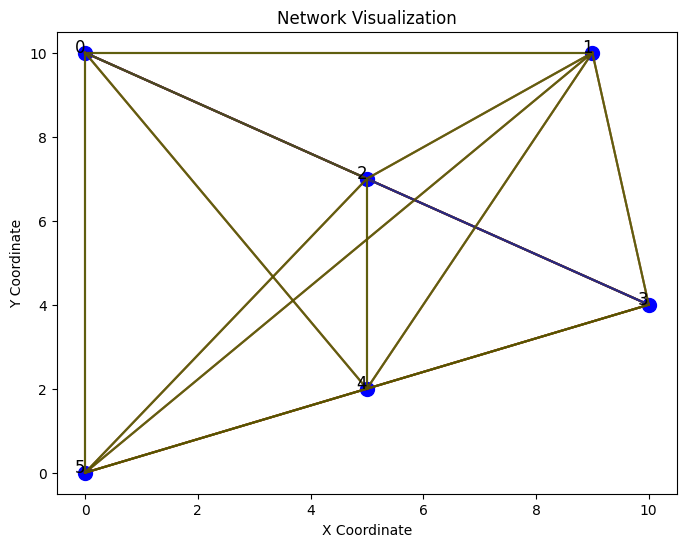

25
[0]
[1, 2, 3, 4, 5]
[[0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]
1000000
1400.0


In [70]:
T, S, C, R, param = parse_instance_file("data/instance_small.txt")
net = Network(S,C,R, param)
net.generate_arcs()
net.visualize()

print(T)
print([s.id for s in S.values()])
print([c.id for c in C.values()])
print(R)
print(param[0][0])
print(sum(c.E for c in C.values()))

In [71]:
from gurobipy import *

In [72]:
T, S, C, rail_matrix, param = parse_instance_file("data/instance_small.txt")

storage_ids = [s.id for s in S.values()]
capture_ids = [c.id for c in C.values()]
nodes = [s for s in S.values()] + [c for c in C.values()]
node_ids = storage_ids + capture_ids
em_carbon = [c.E for c in C.values()]
emissions = dict(zip(capture_ids, em_carbon))

M = sum(c.E for c in C.values())

distance_matrix = [[Arc(i,j,"").dist for i in nodes] for j in nodes]

m = Model("Small_instance")

X = {t: {c: m.addVar(vtype=GRB.BINARY, name=f'x{t},{c}') for c in capture_ids} for t in range(T)}

Y_truck = {t: {i: {j: m.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f'y_truck{t},{i},{j}') for j in node_ids} for i in node_ids} for t in range(T)}
Y_train = {t: {i: {j: m.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f'y_train{t},{i},{j}') for j in node_ids} for i in node_ids} for t in range(T)}
Y_pipe = {t: {i: {j: m.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f'y_pipe{t},{i},{j}') for j in node_ids} for i in node_ids} for t in range(T)}

P = {t: {i: {j: m.addVar(vtype=GRB.BINARY, name=f'p{t},{i},{j}') for j in node_ids} for i in node_ids} for t in range(T)}
F = {i: {j: m.addVar(lb=0, ub=M, vtype=GRB.CONTINUOUS, name=f'f{i},{j}') for j in node_ids} for i in node_ids}
Z = {t: {i: {j: m.addVar(lb=0, ub=M, vtype=GRB.CONTINUOUS, name=f'z{t},{i},{j}') for j in node_ids} for i in node_ids} for t in range(T)}

for t in range(T):
    for i in node_ids:
        for j in node_ids:
            m.addConstr(Y_pipe[t][i][j] - Z[t][i][j] <= 0, name=f'max capacity installed')
for c in capture_ids:
    m.addConstr(quicksum(X[t][c] for t in range(T)) <= 1, name=f"CCS installed at most once on capture site {c}")

for i in node_ids:
    for j in node_ids:
        m.addConstr(quicksum(P[t][i][j] for t in range(T)) <= 1, name=f"CCS installed at most once on capture site {c}")

for t in range(T):
    for i in node_ids:
        for j in node_ids:
            m.addConstr(Z[t][i][j] - M*quicksum(P[t0][i][j] for t0 in range(t+1)) <= 0)
            m.addConstr(Z[t][i][j] >= 0)
            m.addConstr(Z[t][i][j] - F[i][j] <= 0)
            m.addConstr(Z[t][i][j] - F[i][j] + (1 - quicksum(P[t0][i][j] for t0 in range(t+1)))*M >= 0)

for t in range(T):
    for c in capture_ids:
        m.addConstr(quicksum(Y_truck[t][i][c] + Y_train[t][i][c] + Y_pipe[t][i][c] for i in node_ids)
                    - quicksum(Y_truck[t][c][i] + Y_train[t][c][i] + Y_pipe[t][c][i] for i in node_ids)
                    + 0.9*quicksum(X[t0][c] for t0 in range(t+1))*emissions[c] == 0)
    
for t in range(T):
    m.addConstr(quicksum(emissions[c] - 0.9*(quicksum(X[t0][c] for t0 in range(t+1)))*emissions[c] for c in capture_ids) 
                + quicksum(
                    quicksum(
                        (Y_truck[t][i][j]*param[0][2] + Y_train[t][i][j]*param[1][2] + Y_pipe[t][i][j]*param[2][2])*distance_matrix[i][j] for j in node_ids) for i in node_ids) <= -0.5*M*t/T + M)

for t in range(T):
    for i in node_ids:
        for j in node_ids:
            if rail_matrix[i][j] == 0:
                Y_train[t][i][j] == 0

m.setObjective(quicksum(quicksum(quicksum(Y_truck[t][i][j]*param[0][0]*distance_matrix[i][j]+param[0][1]*Y_truck[t][i][j]
                                          + Y_train[t][i][j]*param[1][0]*distance_matrix[i][j]+param[1][1]*Y_train[t][i][j]
                                          for j in node_ids) for i in node_ids) for t in range(T))
                                          + quicksum(quicksum(quicksum(
                                              quicksum(P[k][i][j] for k in range(t))*param[2][4]*distance_matrix[i][j]
                                              + Z[t][i][j]*param[2][3]
                                              for j in node_ids)
                                              for i in node_ids)
                                              for t in range(T)), GRB.MINIMIZE)

m.optimize()


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4691 rows, 4661 columns and 39375 nonzeros
Model fingerprint: 0xc12acaa0
Variable types: 3636 continuous, 1025 integer (1025 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+03]
  Objective range  [3e-01, 1e+07]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 1e+03]
Presolve removed 1502 rows and 752 columns
Presolve time: 0.16s
Presolved: 3189 rows, 3909 columns, 32750 nonzeros
Variable types: 3030 continuous, 879 integer (878 binary)
Found heuristic solution: objective 315209.15361
Found heuristic solution: objective 159950.79383

Root relaxation: objective 3.604064e+03, 1234 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl

In [73]:
net.export_to_csv()